In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast
import torch
import torch.nn as nn
import torch.nn.functional as F

# Data preprocessing

In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = ""
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id', nrows=1000)
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

In [3]:
# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [4]:
# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [5]:
y_train[0:40]

ecg_id
1         [NORM]
2         [NORM]
3         [NORM]
4         [NORM]
5         [NORM]
6         [NORM]
7         [NORM]
8           [MI]
10        [NORM]
11        [NORM]
12        [NORM]
13        [NORM]
14        [NORM]
15        [NORM]
16        [NORM]
17            []
18            []
19        [NORM]
20            []
21        [NORM]
22        [STTC]
23            []
24        [NORM]
25        [NORM]
26        [STTC]
27        [NORM]
28        [STTC]
29        [NORM]
30         [HYP]
31        [NORM]
32          [CD]
33        [NORM]
34            []
35        [NORM]
36        [NORM]
37        [NORM]
39    [STTC, MI]
41          [CD]
42        [NORM]
43        [NORM]
Name: diagnostic_superclass, dtype: object

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform y_train
y_train_encoded = mlb.fit_transform(y_train)

# Transform y_test
y_test_encoded = mlb.transform(y_test)


In [7]:
y_train_encoded[0:40]

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0]])

In [8]:
from sklearn.preprocessing import StandardScaler

# Reshape X_train and X_test to 2D arrays
X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform X_train
X_train_normalized = scaler.fit_transform(X_train_2d)

# Transform X_test using the scaler fitted on the training data
X_test_normalized = scaler.transform(X_test_2d)

# Reshape the normalized data back to 3D arrays
X_train_normalized = X_train_normalized.reshape(X_train.shape)
X_test_normalized = X_test_normalized.reshape(X_test.shape)


In [9]:
X_train[0]

array([[-0.119, -0.055,  0.064, ..., -0.026, -0.039, -0.079],
       [-0.116, -0.051,  0.065, ..., -0.031, -0.034, -0.074],
       [-0.12 , -0.044,  0.076, ..., -0.028, -0.029, -0.069],
       ...,
       [ 0.069,  0.   , -0.069, ...,  0.024, -0.041, -0.058],
       [ 0.086,  0.004, -0.081, ...,  0.242, -0.046, -0.098],
       [ 0.022, -0.031, -0.054, ...,  0.143, -0.035, -0.12 ]])

In [10]:
X_train_normalized[0]

array([[-0.58750481, -0.21148667,  0.33338439, ..., -0.11371942,
        -0.11485571, -0.23213584],
       [-0.57455839, -0.20551289,  0.33464201, ..., -0.12555121,
        -0.10439688, -0.22328593],
       [-0.57388145, -0.17260534,  0.37710371, ..., -0.11427138,
        -0.08913142, -0.20902292],
       ...,
       [ 0.29920911,  0.04117644, -0.24856195, ...,  0.03977347,
        -0.14466081, -0.14651976],
       [ 0.33285364,  0.02528715, -0.30445359, ...,  0.66075497,
        -0.19131544, -0.3107622 ],
       [ 0.05570448, -0.1758299 , -0.21779973, ...,  0.33600234,
        -0.17189612, -0.40157453]])

# Shape of training data
```number of examples x (sampling frequency*10 seconds) x number of channels/leads```

In [11]:
X_train_normalized.shape, y_train_encoded.shape

((871, 1000, 12), (871, 5))

# 3-D to 2-D conversion
``` (Research the best way to do it!)```

In [12]:
# X_train_normalized = X_train_normalized.reshape(X_train_normalized.shape[0], -1)
# X_test_normalized = X_test_normalized.reshape(X_test_normalized.shape[0], -1)

In [13]:
X_train_torch = torch.tensor(X_train_normalized).float()
X_test_torch = torch.tensor(X_test_normalized).float()
y_train_torch = torch.tensor(y_train_encoded).float()
y_test_torch = torch.tensor(y_test_encoded).float()

In [14]:
print(X_train_torch.dtype)

torch.float32


In [15]:
print(X_train_torch.shape)
print(X_test_torch.shape)

torch.Size([871, 1000, 12])
torch.Size([129, 1000, 12])


In [16]:
X_train_torch = X_train_torch.permute(0, 2, 1)  # Swap dimensions to (batch_size, in_channels, input_length)
X_test_torch = X_test_torch.permute(0, 2, 1)

In [17]:
print(X_train_torch.shape)
print(X_test_torch.shape)

torch.Size([871, 12, 1000])
torch.Size([129, 12, 1000])


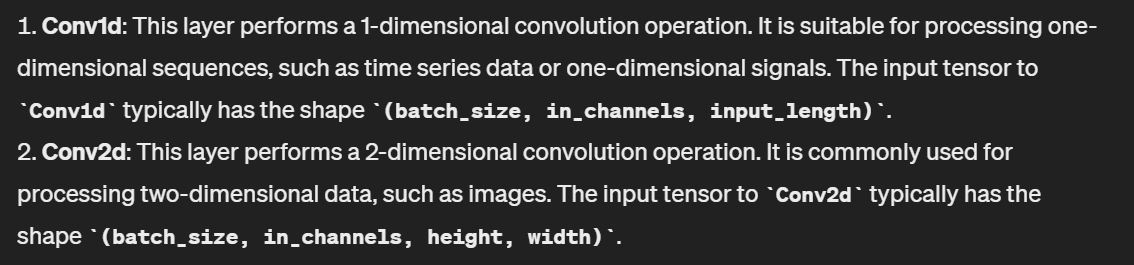

### Test input

In [80]:
test_inp = X_train_torch[0:5]
test_out = y_train_torch[0:5]
print(test_inp.shape)
X_train_torch[:, 0:1, :].shape  # one channel only

torch.Size([5, 12, 1000])


torch.Size([871, 1, 1000])

### 1DCNN block

Apply conv 1d to each lead individually

In [19]:
# Define the Conv1d layer
conv1D = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=11, padding=5) 

# Perform Conv1d operation
output1 = conv1D(X_train_torch[:, 1, :].unsqueeze(1))
output2 = conv1D(X_train_torch[:, 1, :].unsqueeze(1))
output3 = conv1D(X_train_torch[:, 1, :].unsqueeze(1))

output = torch.cat((output1, output2), dim=1)
output = torch.cat((output, output3), dim=1)
# Check the output shape
print(output.shape)

torch.Size([871, 3, 1000])


In [35]:
class CNN1D(nn.Module):
    def __init__(self, kernel_size=16):
        super().__init__()
        self.conv_layer_1 = nn.Conv1d(1, 1, kernel_size=kernel_size)
        self.conv_layer_2 = nn.Conv1d(1, 1, kernel_size=kernel_size)
        self.conv_layer_3 = nn.Conv1d(1, 1, kernel_size=kernel_size)

    def forward(self, x):
        """
        x: [batch_size, in_channels, length]
        output_tensor: [batch_size, in_channels, updated_length]
        """
        # print(x.shape)
        outputs = []
        channels = x.shape[1]
        for i in range(channels):
            input_row = x[:, i:i+1, :]  # (batch_size, channels=1, length=num_columns)
            output_tensor = self.conv_layer_1(input_row)
            output_tensor = self.conv_layer_2(output_tensor)
            output_tensor = self.conv_layer_3(output_tensor)
            # print(output_tensor.shape) # (batch_size, channels=1, length=updated_num_columns)
            outputs.append(output_tensor)

        output_tensor = torch.cat(outputs, dim=1)
        # print(output_tensor.shape)
        return output_tensor

# Define the Conv1D layer
conv1d_layer = CNN1D(kernel_size=128)
output_conv1d = conv1d_layer(test_inp)

print(test_inp.shape)
# Print output shape
print(output_conv1d.shape)

torch.Size([5, 12, 1000])
torch.Size([5, 12, 619])


### Bi-GRU to capture temporal features

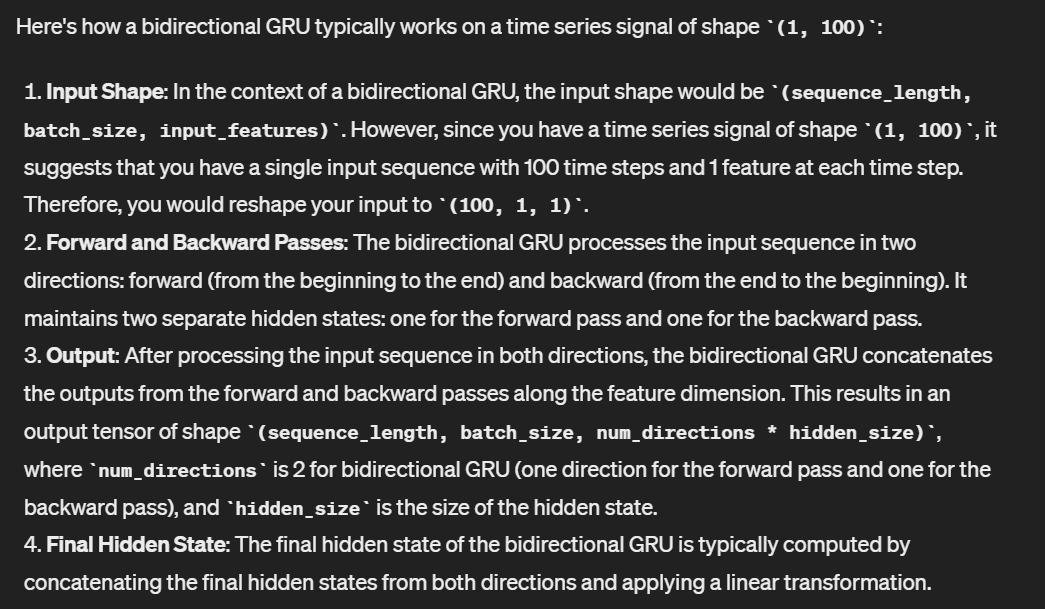

In [38]:
class BiGRU(nn.Module):
    def __init__(self, features_expected=1, hidden_size=64, num_layers=1, bidirectional=True):
        super().__init__()
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.hidden_size = hidden_size
        self.gru = nn.GRU(features_expected, hidden_size, num_layers=num_layers, bidirectional=bidirectional)

    def forward(self, x):
        """
        x: [batch_size, channels, length]
        output_tensor: [batch_size, channels, updated_length]
        """
        # Unpack the dimensions
        batch_size, channels, length = x.size()
        x = x.permute(2, 0, 1)  # [length, batch_size, channels]
        # print(x.shape)

        outputs = []
        for i in range(channels):
            input_lead = x[:, :, i]  # [length, batch_size]
            input_lead = input_lead.unsqueeze(2)  # [sequence_length, batch_size, 1]
            # print(input_lead.shape)
            
            # Pass through the GRU layer
            output_lead, _ = self.gru(input_lead) # [sequence_length, batch_size, 2*hidden_dim]
            # print(output_lead.shape)
            output_lead = output_lead.reshape(batch_size, 1, -1) # [batch_size, 1, sequence_length*2*hidden_dim]
            # print(output_lead.shape)
            outputs.append(output_lead)
        
        output_tensor = torch.cat(outputs, dim=1)  # [batch_size, channels, hidden_size * num_directions]
        return output_tensor

# Define the BiGRU layer
bigru_layer = BiGRU(features_expected=1, hidden_size=8, num_layers=2, bidirectional=True)
output_bigru = bigru_layer(output_conv1d)

# Print input and output shapes
print("Input shape:", output_conv1d.shape)
print("Output shape:", output_bigru.shape)


Input shape: torch.Size([5, 12, 619])
Output shape: torch.Size([5, 12, 9904])


### Max pool block

In [40]:
layer = nn.MaxPool1d(kernel_size=24)
print(output_bigru.shape)
layer(output_bigru).shape

torch.Size([5, 12, 9904])


torch.Size([5, 12, 412])

In [42]:
class MaxPool1DLast(nn.Module):
    def __init__(self, kernel_size=8, stride=None):
        super().__init__()
        self.max_pool = nn.MaxPool1d(kernel_size=kernel_size, stride=stride)

    def forward(self, x):
        """
        x: [batch_size, channels, length]
        pooled_output: [batch_size, channels, reduced_length]
        """
        # Apply max pooling along the last dimension (length)
        pooled_output = self.max_pool(x)
        
        return pooled_output


# Test the class 
windowed_max_pool_layer = MaxPool1DLast(kernel_size=16, stride=None)
output_tensor_max_pool = windowed_max_pool_layer(output_bigru)

# Print input and output shapes
print("Input shape (bigru output):", output_bigru.shape)
print("Output shape:", output_tensor_max_pool.shape)


Input shape (bigru output): torch.Size([5, 12, 9904])
Output shape: torch.Size([5, 12, 619])


### 2DCNN Block

In [24]:
import math

In [25]:
print(test_inp.unsqueeze(1).shape)

torch.Size([5, 1, 12, 1000])


In [26]:
k = 8
conv2d = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(k,100), padding=math.ceil((k-1)/2))

output = conv2d(test_inp.unsqueeze(1))

print(output.shape)

output = output.squeeze()[:, 0:12, :]

print(output.shape)

torch.Size([5, 1, 13, 909])
torch.Size([5, 12, 909])


In [49]:
class CNN2D(nn.Module):
    def __init__(self, kernel_width=4, kernel_height=16):
        super().__init__()
        self.conv_layer_1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(kernel_width, kernel_height), padding=math.ceil((kernel_width-1)/2))
        self.conv_layer_2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(kernel_width, kernel_height), padding=math.ceil((kernel_width-1)/2))
        self.conv_layer_3 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(kernel_width, kernel_height), padding=math.ceil((kernel_width-1)/2))

    def forward(self, x):
        """
        x: [batch_size, channels, num_cols]
        output: [batch, channels, updated_cols]
        """
        # Make the input suitable for 2d convolution, the 2d plane should correspont
        # to channels x num_cols
        x = x.unsqueeze(1)  
        # print(x.shape) # [batch_size, 1, channels, num_cols]

        # Make forward pass
        output = self.conv_layer_1(x) 
        output = output[:, :, 0:12, :]
        # print(output.shape) # [batch_size, 1, 12, num_cols_updated]

        output = self.conv_layer_2(output)
        output = output[:, :, 0:12, :]
        # print(output.shape) # [batch_size, 1, 12, num_cols_updated]

        output = self.conv_layer_3(output)
        output = output.squeeze()[:, 0:12, :]
        # print(output.shape) # [batch_size, 12, num_cols_updated]

        return output
    
    
layer = CNN2D(kernel_width=4, kernel_height=64)
output_2dcnn= layer(output_tensor_max_pool)

print("input:", output_tensor_max_pool.shape)
print('shape of layer output:', output_2dcnn.shape)

input: torch.Size([5, 12, 619])
shape of layer output: torch.Size([5, 12, 442])


### Transformer encoder block

In [28]:
e = nn.TransformerEncoderLayer(d_model=100, nhead=10, dim_feedforward=64)
output = e(output_2dcnn[:, :, :100])

output.shape

torch.Size([5, 12, 100])

In [29]:
t = nn.TransformerEncoder(e, 5)
output = t(output_2dcnn[:, :, :100])

output.shape

c:\Users\PMYLS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([5, 12, 100])

In [30]:
def find_largest_multiple(num, start=2, end=20):
    largest_multiple = None

    # Iterate over the range in reverse order
    for i in range(end, start - 1, -1):
        if num % i == 0:
            largest_multiple = i
            return num, largest_multiple

    # If no multiple found, keep subtracting 1 from the number until a multiple is found
    if largest_multiple is None:
        while True:
            num -= 1
            # Iterate over the range in reverse order
            for i in range(end, start - 1, -1):
                if num % i == 0:
                    largest_multiple = i
                    return num, largest_multiple

# Test the function
number = 47  # Example number
result = find_largest_multiple(number)
print("Updated number:", result[1])
print("Largest multiple:", result[1])


Updated number: 2
Largest multiple: 2


In [50]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, dim_feedforward, num_layers):
        '''
        d_model is the same as length of one eeg channel.
        Since we don't know dmodel and hence nheads, at start, we'll initialize the layers later.
        '''
        super(TransformerEncoderModel, self).__init__()
        self.dim_feedforward = dim_feedforward
        self.num_layers = num_layers
        self.INITIALIZED = False
        
    def forward(self, x):
        batch_size, chan, d_model = x.size()

        if not self.INITIALIZED:
            # n_heads must be a multiple of d_model
            d_model, nhead = self.find_largest_multiple(d_model)
            # If dmodel found is less than the original dmodel:
            x = x[:, :, :d_model]
            self.transformer_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=self.dim_feedforward, batch_first=True)
            self.transformer_encoder = nn.TransformerEncoder(self.transformer_layer, num_layers=self.num_layers)
            self.INITIALIZED = True

        # Apply transformer encoder layers
        output = self.transformer_encoder(x)
        return output

    def find_largest_multiple(self, num, start=2, end=20):
        largest_multiple = None

        # Iterate over the range in reverse order
        for i in range(end, start - 1, -1):
            if num % i == 0:
                largest_multiple = i
                return num, largest_multiple

        # If no multiple found, keep subtracting 1 from the number until a multiple is found
        if largest_multiple is None:
            while True:
                num -= 1
                # Iterate over the range in reverse order
                for i in range(end, start - 1, -1):
                    if num % i == 0:
                        largest_multiple = i
                        return num, largest_multiple

# Test the model with an input tensor
model = TransformerEncoderModel(dim_feedforward=64, num_layers=5)
output_tensor = model(output_2dcnn[:, :, :100])

# Print the output shape
print("Output shape:", output_tensor.shape)

Output shape: torch.Size([5, 12, 100])


### Classifier head

In [75]:
class ClassifierHead(nn.Module):
    def __init__(self, hidden_size):
        super(ClassifierHead, self).__init__()
        self.INITIALIZED = False
        self.hidden_size = hidden_size

    def forward(self, x):
        # Flatten the input tensor
        x = x.view(x.size(0), -1)
        batch_size, input_size = x.size()
        
        if not self.INITIALIZED:
            self.fc1 = nn.Linear(input_size, self.hidden_size) 
            self.fc2 = nn.Linear(self.hidden_size, self.hidden_size//2)
            self.fc3 = nn.Linear(self.hidden_size//2, self.hidden_size//4)
            self.fc4 = nn.Linear(self.hidden_size//4, 5)  # Output layer with 5 classes
            self.INITIALIZED = True
            
        # Apply fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # Output layer with softmax activation for classification
        # x = F.softmax(self.fc4(x), dim=1) # If doing this, use BCE loss
        # OR
        x = self.fc4(x) # Use BCEWithLogitsLoss when doing this
        return x

# Test the network with an input tensor
input_tensor = torch.randn(5, 12, 100)  # Example input tensor with shape [batch_size, channels, length]
classifier = ClassifierHead(256)
output_tensor = classifier(input_tensor)

# Print the output shape
print("Output shape:", output_tensor.shape)
print(output_tensor)

Output shape: torch.Size([5, 5])
tensor([[ 0.1114,  0.1424, -0.0219, -0.0577, -0.0897],
        [ 0.0902,  0.1095, -0.0178, -0.1416, -0.0583],
        [ 0.1004,  0.1032, -0.0077, -0.0736, -0.0590],
        [ 0.0911,  0.1232,  0.0246, -0.0924, -0.0420],
        [ 0.0940,  0.1396,  0.0091, -0.0678, -0.0625]],
       grad_fn=<AddmmBackward0>)


### Loss Function

In [77]:
loss_fn = nn.BCEWithLogitsLoss()
# Logits (without softmax)
predicted = torch.tensor([[ 0.0041, -0.0394,  0.1012,  0.1122, -0.0567],
        [ 0.0051, -0.0586,  0.1237,  0.0958, -0.1053]])
actual = torch.tensor([[1, 1, 1, 1, 0],
       [0, 0, 0, 1, 0]]).float()
loss_fn(predicted, actual).item()

0.6756948232650757

### Classifier

In [81]:
class EEGClassifier(nn.Module):
    def __init__(self, kernel_size_1d_conv=128, num_layers_bi_gru=1, hidden_size_bi_gru=8,
                 kernel_size_max_pool=24, stride_max_pool=None,
                 kernel_width_2d_conv=4, kernel_height_2d_conv=64,
                 dim_feedforward_transformer_encoder=64, num_layers_transformer_encoder=4,
                 hidden_size_classifier_head=256):
        super().__init__()
        # Initialize layers' objects
        self.temporal_feature_extractor_unidirectional = CNN1D(kernel_size=kernel_size_1d_conv)
        self.temporal_feature_extractor_bidirectional = bigru_layer = BiGRU(features_expected=1,
                                                                            hidden_size=hidden_size_bi_gru, 
                                                                            num_layers=num_layers_bi_gru, 
                                                                            bidirectional=True)
        self.max_pool = MaxPool1DLast(kernel_size=kernel_size_max_pool, stride=stride_max_pool)
        self.spectral_feature_extractor = CNN2D(kernel_width=kernel_width_2d_conv, 
                                                kernel_height=kernel_height_2d_conv)
        self.transformer_encoder = TransformerEncoderModel(dim_feedforward=dim_feedforward_transformer_encoder,
                                                           num_layers=num_layers_transformer_encoder)
        self.classifier_head = ClassifierHead(hidden_size_classifier_head)
        self.loss_fn = nn.BCEWithLogitsLoss()

    def forward(self, x, y):
        """
        x: [batch_size, in_channels, length]
        prediction: [batch_size, 5]
        """
        prediction = self.temporal_feature_extractor_unidirectional(x)
        prediction = self.temporal_feature_extractor_bidirectional(prediction)
        prediction = self.max_pool(prediction)
        prediction = self.spectral_feature_extractor(prediction)
        prediction = self.transformer_encoder(prediction)
        prediction = self.classifier_head(prediction)

        loss = None
        if y is not None:
            loss = self.loss_fn(prediction, y.float())
            loss = loss.item()

        return prediction, loss

classifier = EEGClassifier()

prediction, loss = classifier(test_inp, test_out)
print("Input size:", test_inp.size())
print("Prediction:", prediction.size())
print("Loss:", loss)

c:\Users\PMYLS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Input size: torch.Size([5, 12, 1000])
Prediction: torch.Size([5, 5])
Loss: 0.7170900702476501
